# Deep Reinforcement Learning using AlphaZero methodology

Please see https://applied-data.science/blog/how-to-build-your-own-alphazero-ai-using-python-and-keras/ for further notes on the codebase

## 1. First load the core libraries

In [2]:
# -*- coding: utf-8 -*-
# %matplotlib inline

import numpy as np
np.set_printoptions(suppress=True)

from shutil import copyfile
import random


from keras.utils import plot_model

from game import Game, GameState
from agent import Agent
from memory import Memory
from model import Residual_CNN
from funcs import playMatches, playMatchesBetweenVersions

import loggers as lg

import initialize
import pickle
import config

from importlib import reload

Using TensorFlow backend.


## 2. Now run this block to start the learning process

This block loops for ever, continually learning from new game data.

The current best model and memories are saved in the run folder so you can kill the process and restart from the last checkpoint.

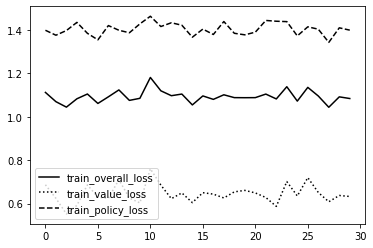




TOURNAMENT...
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 

SCORES
{'best_player': 7, 'drawn': 0, 'current_player': 13}

STARTING PLAYER / NON-STARTING PLAYER SCORES
{'sp': 19, 'drawn': 0, 'nsp': 1}



TOTAL MEMORY SIZE: 51718/300000
ITERATION NUMBER 39
BEST PLAYER VERSION 17
SELF PLAYING 30 EPISODES...
1 
2 
3 


KeyboardInterrupt: 

In [2]:
reload(config)
reload(initialize)

def updateInitFile(memory_version, model_version):
    init_file = open("./initialize.py", "w")
    init_info = 'INITIAL_MEMORY_VERSION = %i\nINITIAL_MODEL_VERSION = %i' % (memory_version, model_version)
    init_file.write(init_info)
    init_file.close()

lg.logger_main.info('=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*')
lg.logger_main.info('=*=*=*=*=*=.      NEW LOG      =*=*=*=*=*')
lg.logger_main.info('=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*')

env = Game()

######## LOAD MEMORIES IF NECESSARY ########

if initialize.INITIAL_MEMORY_VERSION == None:
    memory = Memory(config.MEMORY_SIZE)
    mem_iteration = 0
else:
    print('LOADING MEMORY VERSION ' + str(initialize.INITIAL_MEMORY_VERSION) + '...')
    memory_pickle = open(config.RUN_FOLDER + env.name + "/memory/memory" + str(initialize.INITIAL_MEMORY_VERSION).zfill(4) + ".p", "rb")
    memory = pickle.load(memory_pickle)
    memory_pickle.close()  
    mem_iteration = initialize.INITIAL_MEMORY_VERSION

    #copy the past run's config if continuing from previous run
    copyfile(config.RUN_FOLDER + env.name + '/config.py', './config.py')

######## LOAD MODEL IF NECESSARY ########

# create an untrained neural network objects from the config file
current_NN = Residual_CNN(config.REG_CONST, config.LEARNING_RATE, (2,) + env.grid_shape,   env.action_size, config.HIDDEN_CNN_LAYERS)
best_NN = Residual_CNN(config.REG_CONST, config.LEARNING_RATE, (2,) +  env.grid_shape,   env.action_size, config.HIDDEN_CNN_LAYERS)

#If loading an existing neural network, set the weights from that model
if initialize.INITIAL_MODEL_VERSION != None and initialize.INITIAL_MODEL_VERSION != 0:
    best_player_version  = initialize.INITIAL_MODEL_VERSION
    print('LOADING MODEL VERSION ' + str(initialize.INITIAL_MODEL_VERSION) + '...')
    m_tmp = best_NN.read(env.name, best_player_version)
    current_NN.model.set_weights(m_tmp.get_weights())
    best_NN.model.set_weights(m_tmp.get_weights())

#otherwise just ensure the weights on the two players are the same
else:
    best_player_version = 0
    best_NN.model.set_weights(current_NN.model.get_weights())

#copy the config file to the run folder
copyfile('./config.py', config.RUN_FOLDER + env.name + '/config.py')
plot_model(current_NN.model, to_file=config.RUN_FOLDER + env.name + '/models/model.png', show_shapes = True)

print('\n')

######## CREATE THE PLAYERS ########

current_player = Agent('current_player', env.state_size, env.action_size, config.MCTS_SIMS, config.CPUCT, current_NN)
best_player = Agent('best_player', env.state_size, env.action_size, config.MCTS_SIMS, config.CPUCT, best_NN)
#user_player = User('player1', env.state_size, env.action_size)

while 1:

    mem_iteration += 1
    reload(lg)
    reload(config)
        
    print('TOTAL MEMORY SIZE: ' + str(len(memory.ltmemory)) + "/" + str(config.MEMORY_SIZE)) 
    print('ITERATION NUMBER ' + str(mem_iteration))

    lg.logger_main.info('BEST PLAYER VERSION: %d', best_player_version)
    print('BEST PLAYER VERSION ' + str(best_player_version))

    ######## SELF PLAY ########
    print('SELF PLAYING ' + str(config.EPISODES) + ' EPISODES...')
    _, memory, _, _ = playMatches(best_player, best_player, config.EPISODES, lg.logger_main, 
                                    turns_until_tau0 = config.TURNS_UNTIL_TAU0, memory = memory)
    print('\n')

    memory.clear_stmemory()

    if len(memory.ltmemory) >= config.MEMORY_SIZE:
        print("Ending Training (Reached Full Memory)")
        break

    if len(memory.ltmemory) >= config.MEMORY_BEFORE_TRAINING:

        ######## RETRAINING ########
        print('RETRAINING...')
        current_player.replay(memory.ltmemory)
        print('')

        lg.logger_memory.info('====================')
        lg.logger_memory.info('NEW MEMORIES')
        lg.logger_memory.info('====================')
        
        memory_samp = random.sample(memory.ltmemory, min(1000, len(memory.ltmemory)))
        
        for s in memory_samp:
            current_value, current_probs, _ = current_player.get_preds(s['state'])
            best_value, best_probs, _ = best_player.get_preds(s['state'])

            lg.logger_memory.info('MCTS VALUE FOR %s: %f', s['playerTurn'], s['value'])
            lg.logger_memory.info('CUR PRED VALUE FOR %s: %f', s['playerTurn'], current_value)
            lg.logger_memory.info('BES PRED VALUE FOR %s: %f', s['playerTurn'], best_value)
            lg.logger_memory.info('THE MCTS ACTION VALUES: %s', ['%.2f' % elem for elem in s['AV']]  )
            lg.logger_memory.info('CUR PRED ACTION VALUES: %s', ['%.2f' % elem for elem in  current_probs])
            lg.logger_memory.info('BES PRED ACTION VALUES: %s', ['%.2f' % elem for elem in  best_probs])
            lg.logger_memory.info('ID: %s', s['state'].id)
            lg.logger_memory.info('INPUT TO MODEL: %s', current_player.model.convertToModelInput(s['state']))

            s['state'].render(lg.logger_memory)
            
        ######## TOURNAMENT ########
        print('TOURNAMENT...')
        scores, _, points, sp_scores = playMatches(best_player, current_player, config.EVAL_EPISODES, lg.logger_tourney,                                                                    turns_until_tau0 = 0, memory = None)
        print('\nSCORES')
        print(scores)
        print('\nSTARTING PLAYER / NON-STARTING PLAYER SCORES')
        print(sp_scores)
        #print(points)

        print('\n\n')

        if scores['current_player'] > scores['best_player'] * config.SCORING_THRESHOLD:
            best_player_version += 1
            best_NN.model.set_weights(current_NN.model.get_weights())
            best_NN.write(env.name, best_player_version)
    
    else:
        print('MEMORY BEFORE INITIATING TRAINING: ' + str(len(memory.ltmemory)) + "/" + str(config.MEMORY_BEFORE_TRAINING))
    
    memory_pickle = open(config.RUN_FOLDER + env.name + "/memory/memory" + str(mem_iteration).zfill(4) + ".p", "wb" )
    pickle.dump(memory, memory_pickle)
    memory_pickle.close()
    updateInitFile(mem_iteration, best_player_version)

## The following panels are not involved in the learning process

### Play matches between versions (use -1 for human player)

In [6]:
from game import Game
from funcs import playMatchesBetweenVersions
import loggers as lg

env = Game()
results = np.empty([16, 16, 6], dtype=int)
for y in range(16):
    results_tally = np.array([0, 0, 0, 0, 0, 0])
    for x in range(16):
        if y == 0:
            if x != 0:     
                tournament = open("./run/connect4/tournament.csv", "a+")
                tournament.write(str(x))
                tournament.close()

                starting_player = open("./run/connect4/starting_player.csv", "a+")
                starting_player.write(str(x))
                starting_player.close()
        else:
            if x == 0:
                tournament = open("./run/connect4/tournament.csv", "a+")
                tournament.write(str(y))
                tournament.close()

                starting_player = open("./run/connect4/starting_player.csv", "a+")
                starting_player.write(str(y))
                starting_player.close()
            elif x > y:
                result, _, _, starting_player = playMatchesBetweenVersions(env, y, x, 10, lg.logger_tourney, 0)
                results[y][x] = np.array([  result["player1"], result["drawn"], result["player2"], 
                                            starting_player["sp"], result["drawn"], starting_player["nsp"]])
                results_tally += results[y][x]

                tournament = open("./run/connect4/tournament.csv", "a+")
                tournament.write(str(results[y][x][0] - results[y][x][2]))
                tournament.close()

                starting_player = open("./run/connect4/starting_player.csv", "a+")
                starting_player.write(str(results[y][x][3] - results[y][x][5]))
                starting_player.close()
            elif x < y:
                tournament = open("./run/connect4/tournament.csv", "a+")
                tournament.write(str(results[x][y][2] - results[x][y][0]))
                results_tally += results[x][y]
                tournament.close()
            else:
                result, _, _, starting_player = playMatchesBetweenVersions(env, y, x, 10, lg.logger_tourney, 0)
                results[x][y] = np.array([  result["player1"], result["drawn"], result["player2"], 
                                            starting_player["sp"], result["drawn"], starting_player["nsp"]])

                starting_player = open("./run/connect4/starting_player.csv", "a+")
                starting_player.write(str(results[y][x][3] - results[y][x][5]))
                starting_player.close()

        tournament = open("./run/connect4/tournament.csv", "a+")
        tournament.write(", ")
        tournament.close()

        starting_player = open("./run/connect4/starting_player.csv", "a+")
        starting_player.write(", ")
        starting_player.close()

    tournament = open("./run/connect4/tournament.csv", "a+")
    tournament.write("\n")
    tournament.close()

    starting_player = open("./run/connect4/starting_player.csv", "a+")
    starting_player.write("\n")
    starting_player.close()

    final_tally = open("./run/connect4/final_tally.csv", "a+")
    final_tally.write(str(y))
    for i in results_tally:
        final_tally.write(", ")
        final_tally.write(str(i))
    final_tally.write("\n")
    final_tally.close()

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
1 
2 
3 

### Pass a particular game state through the neural network (setup below for Connect4)

In [5]:
player_version = 15
game = Game()

# create an untrained neural network objects from the config file
player_NN = Residual_CNN(config.REG_CONST, config.LEARNING_RATE, (2,) + game.grid_shape,   game.action_size, config.HIDDEN_CNN_LAYERS)

print('LOADING MODEL VERSION ' + str(player_version) + '...')
m_tmp = player_NN.read(game.name, player_version)
player_NN.model.set_weights(m_tmp.get_weights())

player = Agent('player', game.state_size, game.action_size, config.MCTS_SIMS, config.CPUCT, player_NN)

gs = GameState(np.array([
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 1, 1, 0, 0, 0,
    0, 0, -1, -1, 0, 0, 0,
    0, 1, 1, 1, 0, -1, 0,
    -1, 1, 1, 1, -1, -1, 0,
    -1, -1, -1, 1, -1, 1, 0
]), 1)

_, preds, moves = player.get_preds(gs)
str_preds = ""

for y in range (6):
    for x in range (7):
        str_preds += "%.4f" % preds[x+y*7] + " "
    str_preds += "\n"

print("\nNN predictions:")
print(str_preds)

best_move = 0

for move in moves:
    best_move = move if preds[move] > preds[best_move] else best_move

print (int(best_move/7), best_move % 7)

print("\nMCTS predictions:")

action, pi, _, _ = player.act(gs, 0)
str_pi = ""

for y in range (6):
    for x in range (7):
        str_pi += "%.4f" % pi[x+y*7] + " "
    str_pi += "\n"

print(str_pi)

print (int(action/7), action % 7)

LOADING MODEL VERSION 10...

NN predictions:
0.0000 0.0000 0.0637 0.0624 0.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
0.0000 0.0907 0.0000 0.0000 0.0000 0.3628 0.0000 
0.1655 0.0000 0.0000 0.0000 0.2141 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0409 

2 5

MCTS predictions:
0.0000 0.0000 0.2245 0.0000 0.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.3673 0.0000 
0.1633 0.0000 0.0000 0.0000 0.2449 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 

2 5


### See the layers of the current neural network

LOADING MODEL VERSION 15...
LAYER 0


<Figure size 216x0 with 0 Axes>

LAYER 1


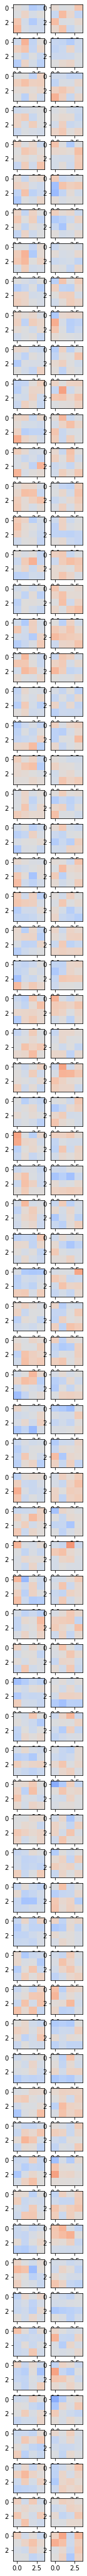

LAYER 2


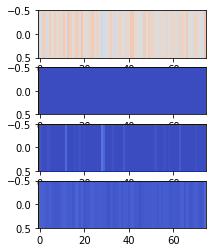

LAYER 3


<Figure size 216x0 with 0 Axes>

LAYER 4


In [8]:
player_version = 15
game = Game()

# create an untrained neural network objects from the config file
player_NN = Residual_CNN(config.REG_CONST, config.LEARNING_RATE, (2,) + game.grid_shape,   game.action_size, config.HIDDEN_CNN_LAYERS)

print('LOADING MODEL VERSION ' + str(player_version) + '...')
m_tmp = player_NN.read(game.name, player_version)
player_NN.model.set_weights(m_tmp.get_weights())

player = Agent('player', game.state_size, game.action_size, config.MCTS_SIMS, config.CPUCT, player_NN)

player.model.viewLayers()

### Output a diagram of the neural network architecture

In [7]:
from keras.utils import plot_model

player_NN = Residual_CNN(config.REG_CONST, config.LEARNING_RATE, (2,) + game.grid_shape,   game.action_size, config.HIDDEN_CNN_LAYERS)
plot_model(player_NN.model, to_file=config.RUN_FOLDER + 'models/model.png', show_shapes = True)

FileNotFoundError: [Errno 2] No such file or directory: './run/models/model.png'

In [ ]:
print (player_NN)